# Educational Guide to Quantum Lattice Boltzmann Method (QLBM)

## Table of Contents
1. Introduction to QLBM
2. Classical Lattice Boltzmann Method Background
3. Quantum Principles for QLBM
4. Basic QLBM Implementation Concepts
5. Simple 1D QLBM Example
6. Advanced Topics and Applications
7. Resources and Further Reading

## 1. Introduction to QLBM

The Quantum Lattice Boltzmann Method (QLBM) is a quantum computing approach for 
simulating fluid dynamics and transport phenomena. It combines the advantages of:
- Classical Lattice Boltzmann Methods (LBM) for fluid simulation
- Quantum computing's potential for exponential speedup

### 1D LBM Animation with Bounce-Back Walls

This notebook implements a classical 1D Lattice Boltzmann Method (LBM) with solid walls at each end and animates the density profile as a pulse travels, collides, and reflects.

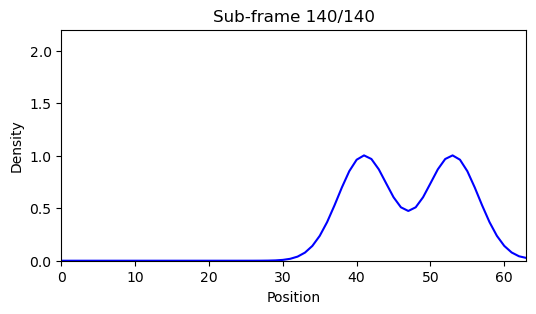

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

class ClassicalLBM1D:
    def __init__(self, nx, dt=1.0, dx=1.0):
        self.nx = nx
        self.dt = dt
        self.dx = dx
        self.velocities = np.array([-1, 1])
        self.weights = np.array([0.5, 0.5])
        self.f = np.zeros((nx, 2))
        self.f_new = np.zeros((nx, 2))
        self.density = np.zeros(nx)

    def set_initial_condition(self, density_func, velocity_func):
        x = np.arange(self.nx)
        dens = density_func(x)
        vel = velocity_func(x)
        self._compute_equilibrium(dens, vel)
        self.f = self.f_eq.copy()
        self.density = dens.copy()

    def _compute_equilibrium(self, dens, vel):
        self.f_eq = np.zeros((self.nx, 2))
        for i in range(self.nx):
            for k, c in enumerate(self.velocities):
                self.f_eq[i,k] = self.weights[k] * dens[i] * (1 + c * vel[i])

    def streaming(self):
        old = self.f.copy()
        self.f_new[:] = 0
        for k, c in enumerate(self.velocities):
            for i in range(self.nx):
                src = i - int(c)
                if src < 0 or src >= self.nx:
                    self.f_new[i,k] = old[i,1-k]
                else:
                    self.f_new[i,k] = old[src,k]
        self.f[:] = self.f_new

    def collision(self, tau=1.0):
        dens = np.sum(self.f, axis=1)
        vel = np.sum(self.f * self.velocities, axis=1) / dens
        vel[np.isnan(vel)] = 0
        self._compute_equilibrium(dens, vel)
        self.f += -(1/tau)*(self.f - self.f_eq)

    def one_step_subframes(self, tau=1.2):
        self.streaming()
        dens_s = np.sum(self.f, axis=1).copy()
        self.collision(tau)
        dens_c = np.sum(self.f, axis=1).copy()
        return dens_s, dens_c

def create_gaussian_pulse(x, center, width, amplitude=1.0):
    return amplitude * np.exp(-((x-center)/width)**2)

def generate_subframes(nx=64, n_steps=70, tau=1.2):
    lbm = ClassicalLBM1D(nx)
    lbm.set_initial_condition(
        lambda x: create_gaussian_pulse(x, nx//4, 5.0, 2.0),
        lambda x: np.full_like(x, 0.2)
    )
    frames = []
    for _ in range(n_steps):
        s, c = lbm.one_step_subframes(tau)
        frames.append(s)
        frames.append(c)
    return np.array(frames)

subframes = generate_subframes()
fig, ax = plt.subplots(figsize=(6,3))
line, = ax.plot(subframes[0], 'b')
ax.set_xlim(0, subframes.shape[1]-1)
ax.set_ylim(0, subframes.max()*1.1)
ax.set_xlabel('Position')
ax.set_ylabel('Density')

def update(frame):
    line.set_ydata(subframes[frame])
    ax.set_title(f'Sub-frame {frame+1}/{len(subframes)}')
    return line,

anim = animation.FuncAnimation(
    fig, update, frames=len(subframes),
    interval=100, blit=True
)
from IPython.display import HTML
HTML(anim.to_jshtml())

### Key Advantages
- Quantum superposition allows encoding multiple flow directions simultaneously
- Potential exponential memory and computational advantages
- Natural mapping between probability-based classical LBM and quantum states
- Suitable for complex boundary conditions and multiphysics simulations

### Applications
- Computational Fluid Dynamics (CFD)
- Advection-diffusion equations
- Heat transfer simulations
- Multiphase flow problems
- Acoustic simulations

## 2. Classical Lattice Boltzmann Method Background

The classical LBM simulates fluid flow using fictitious particles on a lattice:

### Basic Concepts
- **Distribution Functions (f_i)**: Represent particle populations moving in discrete velocities
- **Streaming Step**: Particles move to neighboring lattice sites
- **Collision Step**: Particles interact and redistribute at each site
- **Macroscopic Variables**: Density and velocity obtained by summing distribution functions

### D1Q2 Model (1D, 2 velocities)
In the simplest case, particles can move in two directions: left and right.

### LBM Equation
f_i(x + c_i*Δt, t + Δt) = f_i(x,t) - (1/τ)[f_i(x,t) - f_i^eq(x,t)]

Where:
- f_i: distribution function for direction i
- c_i: discrete velocity vector
- τ: relaxation time
- f_i^eq: equilibrium distribution function

## 3. Quantum Principles for QLBM

### Quantum State Encoding
- Distribution functions are encoded in quantum amplitudes
- Quantum superposition represents multiple velocity directions
- Entanglement connects spatial and velocity information

### Quantum Operations
- **Streaming**: Implemented as quantum shift operations
- **Collision**: Quantum rotation operations on velocity space
- **Boundary Conditions**: Controlled quantum operations

### Quantum Advantages
- Exponential memory scaling: N grid points require O(log N) qubits
- Parallel processing of multiple flow directions
- Natural probabilistic interpretation

## 4. Basic QLBM Implementation Concepts

### Key Components
1. **Quantum State Preparation**: Initialize velocity distribution
2. **Streaming Operator**: Quantum gates for particle movement
3. **Collision Operator**: Quantum gates for relaxation
4. **Measurement**: Extract macroscopic quantities

### Circuit Structure
- Position qubits: Encode spatial locations
- Velocity qubits: Encode particle directions
- Auxiliary qubits: For complex operations

## 5. Simple 1D QLBM Example

Here's a basic implementation concept for a 1D advection-diffusion problem:

Measurement counts: {'101': 399, '111': 449, '010': 74, '000': 69, '110': 455, '100': 446, '011': 78, '001': 78}


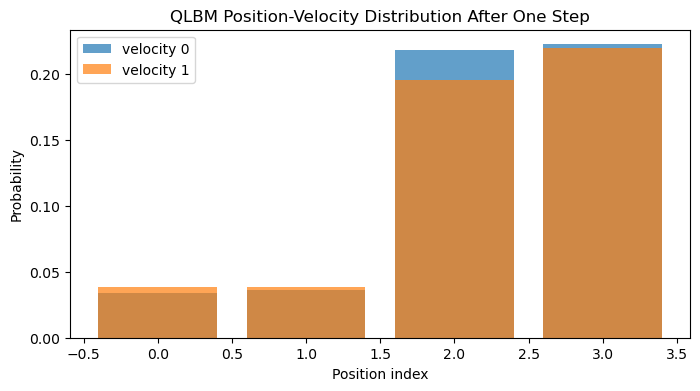

In [47]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# --- QLBM model parameters ---
n_sites = 4      # Number of lattice sites (2 qubits for positions)
n_velocities = 2 # D1Q2: left/right; (1 qubit for velocities)

n_pos_qubits = int(np.log2(n_sites))
n_vel_qubits = int(np.log2(n_velocities))

# --- State Preparation (all sites, both velocities in superposition, like a flat density) ---
qr = QuantumRegister(n_pos_qubits + n_vel_qubits, 'q')
cr = ClassicalRegister(n_pos_qubits + n_vel_qubits, 'c')
qc = QuantumCircuit(qr, cr)

# Prepare equal superposition over all positions and velocities
for i in range(n_pos_qubits + n_vel_qubits):
    qc.h(qr[i])

# --- Streaming Step (shift depending on velocity qubit) ---
# For each position bit, controlled-X with velocity as control
# Velocity qubit = last qubit = qr[n_pos_qubits]
# Shift the least significant position bit
qc.cx(qr[n_pos_qubits], qr[0])  # Only acting on smallest bit for demonstration (works for 4 sites)

# --- Collision Step (local rotation in velocity space) ---
# At every site, rotate the velocity qubit (relax toward equilibrium)
theta = np.pi / 4  # illustrative (relaxation strength)
qc.ry(theta, qr[n_pos_qubits])  # Rotate velocity qubit

# --- Measurement ---
qc.measure(qr, cr)

# --- Simulate circuit ---
sim = AerSimulator(shots=2048)
result = sim.run(qc).result()
counts = result.get_counts(qc)
print("Measurement counts:", counts)

# --- Optional: visualize probabilities along (position,velocity) basis ---
keys = [f'{i:0{n_pos_qubits+n_vel_qubits}b}' for i in range(2 ** (n_pos_qubits + n_vel_qubits))]
probs = np.array([counts.get(k, 0) for k in keys]) / sum(counts.values())

positions = [int(k[:-1], 2) for k in keys]  # all bits except last
velocities = [int(k[-1]) for k in keys]     # last bit

plt.figure(figsize=(8,4))
for v in range(n_velocities):
    plt.bar(
        [p for p, vel in zip(positions, velocities) if vel==v],
        [probs[i] for i, vel in enumerate(velocities) if vel==v],
        alpha=0.7, label=f'velocity {v}')
plt.xlabel("Position index")
plt.ylabel("Probability")
plt.title("QLBM Position-Velocity Distribution After One Step")
plt.legend()
plt.show()


=== QLBM Quantum Circuit Demonstration ===

Configuration 1: 4 sites, 2 velocities, bounce-back
QLBM Circuit: 4 sites, 2 velocities
Qubits: 3, Depth: 10
Boundary: bounce_back, tau: 1.2

Circuit structure:
       ┌───┐ State_Prep ┌───┐      Streaming                             Collision ┌───┐     ┌───┐      Boundaries ┌─┐      
pos_0: ┤ H ├─────░──────┤ X ├──────────░────────────────────────■────────────░─────┤ X ├──■──┤ X ├──■───────░──────┤M├──────
       ├───┤     ░      └─┬─┘┌───┐     ░                        │            ░     ├───┤  │  ├───┤  │       ░      └╥┘┌─┐   
pos_1: ┤ H ├─────░────────┼──┤ X ├─────░────────────────────────┼────────────░─────┤ X ├──■──┤ X ├──■───────░───────╫─┤M├───
       ├───┤     ░        │  └─┬─┘     ░     ┌───────────┐┌─────┴──────┐     ░     └───┘┌─┴─┐└───┘┌─┴─┐     ░       ║ └╥┘┌─┐
  vel: ┤ H ├─────░────────■────■───────░─────┤ Ry(5π/12) ├┤ Ry(0.6545) ├─────░──────────┤ X ├─────┤ X ├─────░───────╫──╫─┤M├
       └───┘     ░                     ░     

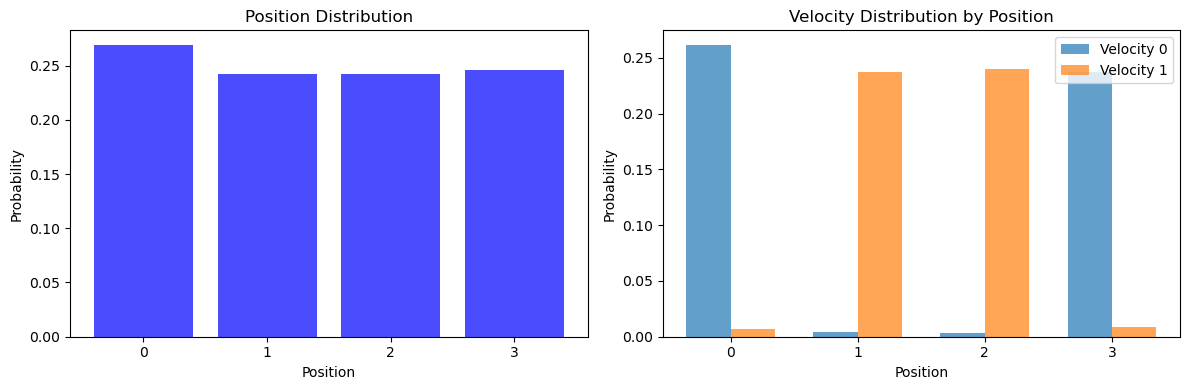



Configuration 2: 8 sites, 2 velocities, periodic
QLBM Circuit: 8 sites, 2 velocities
Qubits: 4, Depth: 6
Boundary: periodic, tau: 1.0

Circuit structure:
       ┌───┐ State_Prep ┌───┐      Streaming                        Collision  Boundaries ┌─┐         
pos_0: ┤ H ├─────░──────┤ X ├──────────░─────────────────────■──────────░──────────░──────┤M├─────────
       ├───┤     ░      └─┬─┘┌───┐     ░                     │          ░          ░      └╥┘┌─┐      
pos_1: ┤ H ├─────░────────┼──┤ X ├─────░─────────────────────┼──────────░──────────░───────╫─┤M├──────
       ├───┤     ░        │  └─┬─┘     ░                     │          ░          ░       ║ └╥┘┌─┐   
pos_2: ┤ H ├─────░────────┼────┼───────░─────────────────────┼──────────░──────────░───────╫──╫─┤M├───
       ├───┤     ░        │    │       ░     ┌─────────┐┌────┴────┐     ░          ░       ║  ║ └╥┘┌─┐
  vel: ┤ H ├─────░────────■────■───────░─────┤ Ry(π/2) ├┤ Ry(π/4) ├─────░──────────░───────╫──╫──╫─┤M├
       └───┘     ░  

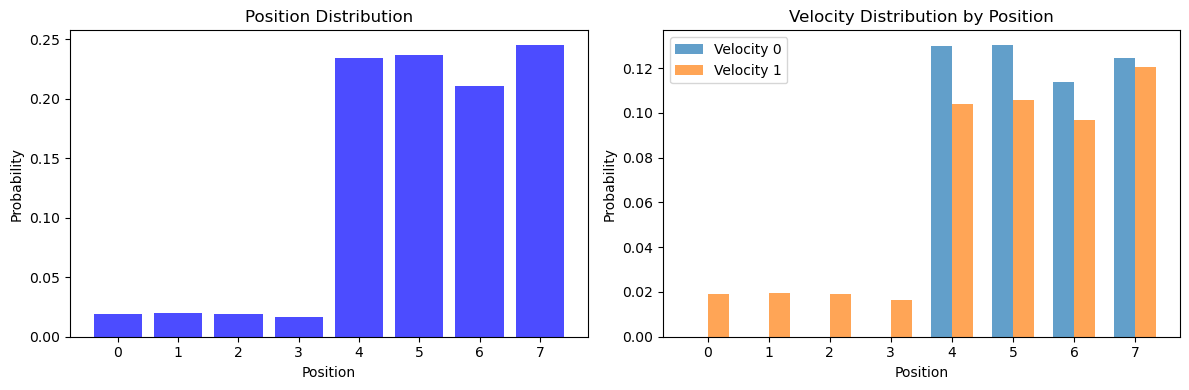



Configuration 3: 4 sites, 4 velocities, periodic
QLBM Circuit: 4 sites, 4 velocities
Qubits: 4, Depth: 7
Boundary: periodic, tau: 0.8

Circuit structure:
       ┌───┐ State_Prep ┌───┐┌───┐      Streaming                           Collision  Boundaries ┌─┐         
pos_0: ┤ H ├─────░──────┤ X ├┤ X ├──────────░───────────────────────■───────────░──────────░──────┤M├─────────
       ├───┤     ░      └─┬─┘└─┬─┘┌───┐     ░                       │           ░          ░      └╥┘┌─┐      
pos_1: ┤ H ├─────░────────┼────┼──┤ X ├─────░───────────────────────┼───────────░──────────░───────╫─┤M├──────
       ├───┤     ░        │    │  └─┬─┘     ░     ┌──────────┐┌─────┴─────┐     ░          ░       ║ └╥┘┌─┐   
vel_0: ┤ H ├─────░────────■────┼────■───────░─────┤ Ry(5π/8) ├┤ Ry(5π/16) ├─────░──────────░───────╫──╫─┤M├───
       ├───┤     ░             │    │       ░     ├──────────┤└───────────┘     ░          ░       ║  ║ └╥┘┌─┐
vel_1: ┤ H ├─────░─────────────■────■───────░─────┤ Ry(5π/8) ├─────

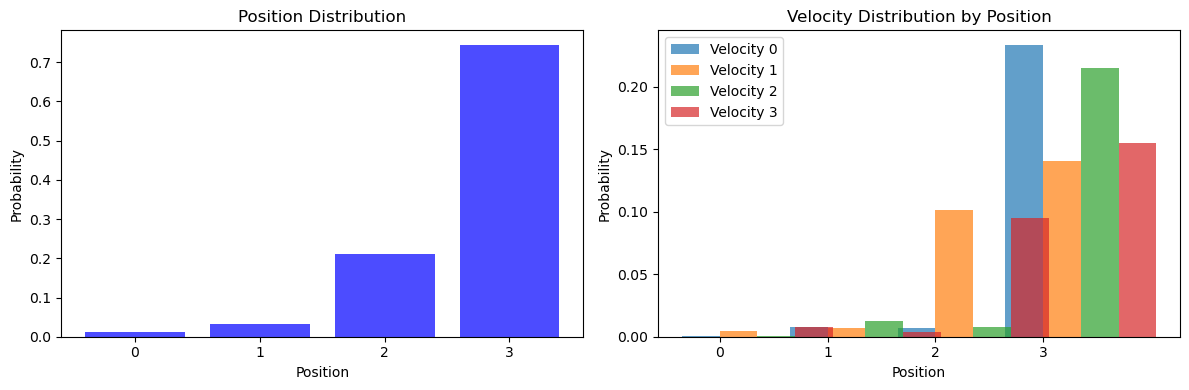


Simulation completed!


In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

def create_qlbm_circuit(n_sites, n_velocities, tau=1.0, boundary="periodic"):
    """
    Create a general QLBM circuit
    
    Args:
        n_sites: Number of spatial lattice sites (power of 2)
        n_velocities: Number of discrete velocities (power of 2)
        tau: Relaxation time parameter
        boundary: "periodic" or "bounce_back"
    """
    n_pos = int(np.log2(n_sites))
    n_vel = int(np.log2(n_velocities))
    
    pos = QuantumRegister(n_pos, 'pos')
    vel = QuantumRegister(n_vel, 'vel')
    cr = ClassicalRegister(n_pos + n_vel, 'c')
    qc = QuantumCircuit(pos, vel, cr)

    # --- State preparation: equal superposition ---
    for i in range(n_pos):
        qc.h(pos[i])
    for i in range(n_vel):
        qc.h(vel[i])
    qc.barrier(label="State_Prep")

    # --- Streaming: controlled position shift based on velocity ---
    if n_velocities == 2:  # D1Q2 case
        # Simple streaming: vel[0] controls increment of position
        qc.cx(vel[0], pos[0])
        if n_pos > 1:
            qc.cx(vel[0], pos[1])
    elif n_velocities == 4:  # D1Q4 case
        # More complex streaming patterns
        qc.cx(vel[0], pos[0])
        qc.cx(vel[1], pos[0])
        if n_pos > 1:
            qc.ccx(vel[0], vel[1], pos[1])
    
    qc.barrier(label="Streaming")

    # --- Collision: velocity space rotation ---
    theta = np.pi / (2 * tau)
    for i in range(n_vel):
        qc.ry(theta, vel[i])
    
    # Position-dependent collision (optional enhancement)
    if n_sites >= 4:
        qc.cry(theta * 0.5, pos[0], vel[0])
    
    qc.barrier(label="Collision")

    # --- Boundary conditions ---
    if boundary == "bounce_back" and n_sites == 4 and n_velocities == 2:
        # Left wall: swap velocity if at position 0 (|00>)
        qc.x(pos[0])  # Control on |0>
        qc.x(pos[1])  # Control on |0>
        qc.ccx(pos[0], pos[1], vel[0])  # Flip velocity if at |00>
        qc.x(pos[0])  # Restore
        qc.x(pos[1])  # Restore
        
        # Right wall: swap velocity if at position 3 (|11>)
        qc.ccx(pos[0], pos[1], vel[0])  # Flip velocity if at |11>
    
    qc.barrier(label="Boundaries")

    # --- Measurement ---
    qc.measure(pos, cr[:n_pos])
    qc.measure(vel, cr[n_pos:n_pos+n_vel])
    
    return qc

def run_qlbm_simulation(n_sites=4, n_velocities=2, tau=1.2, boundary="bounce_back", shots=2048):
    """
    Run a complete QLBM simulation and analyze results
    """
    # Create circuit
    qc = create_qlbm_circuit(n_sites, n_velocities, tau, boundary)
    
    print(f"QLBM Circuit: {n_sites} sites, {n_velocities} velocities")
    print(f"Qubits: {qc.num_qubits}, Depth: {qc.depth()}")
    print(f"Boundary: {boundary}, tau: {tau}")
    print("\nCircuit structure:")
    print(qc.draw(fold=-1))
    
    # Simulate
    sim = AerSimulator(shots=shots)
    result = sim.run(qc).result()
    counts = result.get_counts(qc)
    
    print(f"\nMeasurement results ({shots} shots):")
    for state, count in sorted(counts.items()):
        print(f"  {state}: {count}")
    
    return qc, counts

def analyze_results(counts, n_sites, n_velocities):
    """
    Analyze and visualize QLBM results
    """
    n_pos = int(np.log2(n_sites))
    n_vel = int(np.log2(n_velocities))
    
    # Parse measurement results
    total_shots = sum(counts.values())
    position_probs = np.zeros(n_sites)
    velocity_probs = np.zeros((n_sites, n_velocities))
    
    for state, count in counts.items():
        # Parse binary string: first n_pos bits = position, last n_vel bits = velocity
        pos_bits = state[:n_pos]
        vel_bits = state[n_pos:]
        
        pos_idx = int(pos_bits, 2) if pos_bits else 0
        vel_idx = int(vel_bits, 2) if vel_bits else 0
        
        prob = count / total_shots
        position_probs[pos_idx] += prob
        velocity_probs[pos_idx, vel_idx] = prob
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Position distribution
    ax1.bar(range(n_sites), position_probs, alpha=0.7, color='blue')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.set_title('Position Distribution')
    ax1.set_xticks(range(n_sites))
    
    # Velocity distribution at each position
    width = 0.35
    x_pos = np.arange(n_sites)
    for v in range(n_velocities):
        ax2.bar(x_pos + v*width, velocity_probs[:, v], width, 
                alpha=0.7, label=f'Velocity {v}')
    
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.set_title('Velocity Distribution by Position')
    ax2.set_xticks(x_pos + width/2)
    ax2.set_xticklabels(range(n_sites))
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return position_probs, velocity_probs

def main():
    """
    Main function to run different QLBM configurations
    """
    print("=== QLBM Quantum Circuit Demonstration ===\n")
    
    # Configuration 1: Basic 4-site, 2-velocity with bounce-back
    print("Configuration 1: 4 sites, 2 velocities, bounce-back")
    qc1, counts1 = run_qlbm_simulation(n_sites=4, n_velocities=2, tau=1.2, boundary="bounce_back")
    pos_probs1, vel_probs1 = analyze_results(counts1, 4, 2)
    """
    print("\n" + "="*60 + "\n")
    
    # Configuration 2: 8-site system
    print("Configuration 2: 8 sites, 2 velocities, periodic")
    qc2, counts2 = run_qlbm_simulation(n_sites=8, n_velocities=2, tau=1.0, boundary="periodic")
    pos_probs2, vel_probs2 = analyze_results(counts2, 8, 2)
    
    print("\n" + "="*60 + "\n")
    
    # Configuration 3: 4-velocity system
    print("Configuration 3: 4 sites, 4 velocities, periodic")
    qc3, counts3 = run_qlbm_simulation(n_sites=4, n_velocities=4, tau=0.8, boundary="periodic")
    pos_probs3, vel_probs3 = analyze_results(counts3, 4, 4)
    """
    print("\nSimulation completed!")

if __name__ == "__main__":
    main()
